In [325]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
from ast import literal_eval
import seaborn as sns
import json

In [2]:
rng = np.random.default_rng(3844)

# Datasets

Simulated parameters and transcript counts for high (1.0), medium (0.5) and low (0.06) mean capture efficiencies.

'counts_x' are simulated with each cell's capture efficiency equal to the mean \
'counts_x_sampled' are simulated with each cell's capture efficiency sampled from a beta distribution

In [48]:
# mean capture efficiency for each cell
beta_high = np.array([1.0 for j in range(1000)])
params_high = pd.read_csv("params_high.csv", index_col=0)
counts_high = pd.read_csv("counts_high.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_med = np.array([0.5 for j in range(1000)])
params_med = pd.read_csv("params_med.csv", index_col=0)
counts_med = pd.read_csv("counts_med.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_low = np.array([0.06 for j in range(1000)])
params_low = pd.read_csv("params_low.csv", index_col=0)
counts_low = pd.read_csv("counts_low.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})

# sampled capture efficiency for each cell
beta_high_sampled = np.loadtxt("beta_high_sampled.csv", delimiter=",")
params_high_sampled = pd.read_csv("params_high_sampled.csv", index_col=0)
counts_high_sampled = pd.read_csv("counts_high_sampled.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_med_sampled = np.loadtxt("beta_med_sampled.csv", delimiter=",")
params_med_sampled = pd.read_csv("params_med_sampled.csv", index_col=0)
counts_med_sampled = pd.read_csv("counts_med_sampled.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_low_sampled = np.loadtxt("beta_low_sampled.csv", delimiter=",")
params_low_sampled = pd.read_csv("params_low_sampled.csv", index_col=0)
counts_low_sampled = pd.read_csv("counts_low_sampled.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})

# revised datasets: interaction
params_high_revised = pd.read_csv("params_high_revised.csv", index_col=0)
counts_high_revised = pd.read_csv("counts_high_revised.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
params_med_revised = pd.read_csv("params_med_revised.csv", index_col=0)
counts_med_revised = pd.read_csv("counts_med_revised.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})

# revised datasets: no interaction
params_high_revised_noInt = pd.read_csv("params_high_revised_noInt.csv", index_col=0)
counts_high_revised_noInt = pd.read_csv("counts_high_revised_noInt.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
params_med_revised_noInt = pd.read_csv("params_med_revised_noInt.csv", index_col=0)
counts_med_revised_noInt = pd.read_csv("counts_med_revised_noInt.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})

# Bootstrap

In [4]:
def bootstrap_data(samples, BS=1000, thresh=1, plot=False, printing=False):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    computing empirical distribution over multiple bootstrap samples

    samples: list of tuples of (x1, x2) counts per cell
    BS: number of bootstrap resamples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    '''

    # sample size
    n = len(samples)

    # compute maximum x1 and x2 values
    M, N = np.max(samples, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [x[1] + (N + 1)*x[0] for x in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(BS, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(BS)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=BS*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # compute 2.5% and 97.5% quantiles for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # set truncation bounds
    m_OB, n_OB, M_OB, N_OB = M, N, 0, 0

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < m_OB:
                    m_OB = x1
                if x2 < n_OB:
                    n_OB = x2
                # check if larger than current max
                if x1 > M_OB:
                    M_OB = x1
                if x2 > N_OB:
                    N_OB = x2

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= m_OB) and (x2 >= n_OB) and (x1 <= M_OB) and (x2 <= N_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2]);
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

    if printing:
        print(f"Box truncation: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}]")

    results =  {
        'samples': samples,
        'sample_counts': sample_counts,
        'joint': bounds,
        'm_OB': m_OB,
        'n_OB': n_OB,
        'M_OB': M_OB,
        'N_OB': N_OB
    }

    return results

# Optimization

In [5]:
def B(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j): product of binomials.'''

    val = 0.0

    # compute binomial probability
    if (x1_OB <= x1_OG) and (x2_OB <= x2_OG):

        bin_coef_x1 = scipy.special.comb(x1_OG, x1_OB)
        bin_coef_x2 = scipy.special.comb(x2_OG, x2_OB)

        for beta_j in beta:

            p1 = beta_j**x1_OB * (1 - beta_j)**(x1_OG - x1_OB)
            p2 = beta_j**x2_OB * (1 - beta_j)**(x2_OG - x2_OB)
            val += p1 * p2

        n = beta.shape[0]
        val = float(bin_coef_x1 * bin_coef_x2 * val / n)

        return val
    
    # asssume we cannot observe more counts than are present originally
    else:
        return val

In [6]:
def findTrunc(x1_OB, x2_OB, beta, thresh):
    '''
    Return the first pair of states (x1_OG, x2_OG) which
    have B(x1_OB, x2_OB, x1_OG, x2_OG, beta) < thresh
    '''

    x1_OG, x2_OG = x1_OB, x2_OB
    bp = 1
    while bp > thresh:
        
        # increment
        x1_OG += 1
        x2_OG += 1

        # compute
        bp = B(x1_OB, x2_OB, x1_OG, x2_OG, beta)

    return x1_OG, x2_OG

In [7]:
def preComputeTruncation(M, N, beta, thresh):
    '''
    Compute M x N values of original truncations

    M, N: shape of observed pairs that truncations are computed for
    beta: capture efficiency vector
    thresh: threshold for trunction
    '''
    truncations = {}
    for x1_OB in range(M):
        truncations[x1_OB] = {}
        for x2_OB in range(N):
            x1_OG, x2_OG = findTrunc(x1_OB, x2_OB, beta, thresh)
            truncations[x1_OB][x2_OB] = (x1_OG, x2_OG)

    return truncations

Functions to compute the truncation point of the 'B-method' sum over original counts.

'preComputeTruncation' allows these values to be pre-computed and passed to optimization to save time during model construction 

## Standard Method

Optimize for the minima of $k_{reg}$, terminating early if a non-zero lower bound is obtained

In [251]:
def optimization_min(bounds, beta, truncations, K=100, silent=True,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001):
    '''
    Minimize k_reg subject to constraints, terminating early if non-zero lower
    bound is obtained

    bounds: contains 2 x M x N array of confidence interval bounds on stat. dist. of system
            and observed truncation information
    beta: capture efficiency vector
    truncations: pre-computed dict of original truncations

    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    print_solution: toggle for printing optimization solution
    print_truncation: toggle for printing truncation information
    thresh_trunc: threshold on B coefficients for original truncation
    MIPGap: GUROBI parameter
    time_limit: time limit on optimization before termination (5 min default)
    BestBdThresh: size of non-zero lower bound on k_reg needed to terminate early
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # optimization settings
    md.Params.MIPGap = MIPGap

    '''experimental'''
    # aggressive presolve
    md.Params.Presolve = 2
    # focus on lower bound of objective: allows early termination
    md.Params.MIPFocus = 3

    # set threshold on BestBd for termination
    md.Params.BestBdStop = BestBdThresh

    # State space truncations

    # observed truncations: computed during bootstrap
    m_OB = bounds['m_OB']
    n_OB = bounds['n_OB']
    M_OB = bounds['M_OB']
    N_OB = bounds['N_OB']

    # find largest original truncations: (pre)computed by thresholding coefficients
    M_OG, N_OG = 0, 0
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            try:
                # lookup
                m_OG, n_OG = truncations[x1_OB][x2_OB]
            except KeyError:
                # compute if not available
                m_OG, n_OG = findTrunc(x1_OB, x2_OB, beta, thresh_trunc)
                # store
                try:
                    truncations[x1_OB][x2_OB] = (m_OG, n_OG)
                except KeyError:
                    # add new level to dict
                    truncations[x1_OB] = {x2_OB: (m_OG, n_OG)}

            # update largest values
            if m_OG > M_OG:
                M_OG = m_OG
            if n_OG > N_OG:
                N_OG = n_OG

    if print_truncation:
        print(f"Observed counts: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}] \nOriginal counts: [0, {M_OG - 1}] x [0, {N_OG - 1}]")

    # variables

    # stationary distribution: original counts (size = largest truncation)
    p = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # fix k_deg_2 = 1 for identifiability
    md.addConstr(rates['k_deg_2'] == 1)

    # stationary distribution bounds: for each observed count
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):

            # individual truncation: lookup from pre-computed dict
            m_OG, n_OG = truncations[x1_OB][x2_OB]

            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p[x1_OG, x2_OG] for x1_OG in range(m_OG) for x2_OG in range(n_OG)])
            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p[x1_OG, x2_OG + 1] + \
                rates['k_reg'] * (x1_OG + 1) * (x2_OG + 1) * p[x1_OG + 1, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG + \
                 rates['k_reg'] * x1_OG * x2_OG) * p[x1_OG, x2_OG] == 0,
                name=f"Equation {x1_OG}, {x2_OG}"
                )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'k_tx_1': "v",
        'k_tx_2': "v",
        'k_deg_1': "v",
        'k_deg_2': 1,
        'k_reg': None
    }

    # Optimize

    # set objective: minimize interaction parameter
    md.setObjective(rates['k_reg'], GRB.MINIMIZE)

    # attempt to optimize
    try:
        md.optimize()
        min_val = md.ObjVal
    except:
        min_val = None

    # report status
    status_min = status_codes[md.status]

    # record
    solution['k_reg'] = [min_val, status_min]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'k_reg':
                if val[1] == 'USER_OBJ_LIMIT':
                    print(f"{key} non-zero lower bound found, early termination status {val[1]}")
                else:
                    print(f"{key} lower bound {val[0]}, status {val[1]}")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

### Example

In [9]:
# pre-compute truncations for a given capture efficiency
truncations_high = preComputeTruncation(30, 30, beta_high, 10**-6)
truncations_med = preComputeTruncation(30, 30, beta_med, 10**-6)
truncations_low = preComputeTruncation(30, 30, beta_low, 10**-6)

In [254]:
# select a gene pair: 18, 24, 45, 47, 52, 58, 59 (some examples where not all counts of a gene are = 0)
i = 59

# select sample
samples_high = list(counts_high.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_high = bootstrap_data(samples_high, BS=1000, thresh=10, printing=True)

Box truncation: [0, 11] x [0, 3]


In [255]:
# optimize
solution_high_min = optimization_min(bounds_high, beta_high, truncations_high, K=100, silent=False,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Presolve to value 2
Set parameter MIPFocus to value 3
Set parameter BestBdStop to value 0.0001
Observed counts: [0, 11] x [0, 3] 
Original counts: [0, 11] x [0, 3]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 98 rows, 53 columns and 145 nonzeros
Model fingerprint: 0x32d60160
Model has 33 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [5e-03, 1e+00]
Presolve removed 97 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve 

In [256]:
# true interaction value > 0
params_high.loc[f'Gene-pair-{i}']

k_tx_1     3.212642
k_tx_2     2.671750
k_deg_1    0.234658
k_deg_2    0.612194
k_reg      6.121941
Name: Gene-pair-59, dtype: float64

### Example

In [306]:
# pre-compute truncations for a given capture efficiency
truncations_high_sampled = preComputeTruncation(30, 30, beta_high_sampled, 10**-6)
truncations_med_sampled = preComputeTruncation(30, 30, beta_med_sampled, 10**-6)
truncations_low_sampled = preComputeTruncation(30, 30, beta_low_sampled, 10**-6)

In [304]:
# select a gene pair
i = 2

# select sample
samples_high_sampled = list(counts_high_sampled.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_high_sampled = bootstrap_data(samples_high_sampled, BS=1000, thresh=10, printing=True)

Box truncation: [0, 1] x [1, 18]


In [307]:
# optimize
solution_high_sampled_min = optimization_min(bounds_high_sampled, beta_high_sampled, truncations_high_sampled, K=100, silent=False,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Presolve to value 2
Set parameter MIPFocus to value 3
Set parameter BestBdStop to value 0.0001
Observed counts: [0, 1] x [1, 18] 
Original counts: [0, 7] x [0, 24]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 74 rows, 205 columns and 2933 nonzeros
Model fingerprint: 0x40b1bf7b
Model has 168 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-07, 1e+00]
  QMatrix range    [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [4e-03, 1e+00]
Presolve removed 52 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presol

In [308]:
# true interaction value > 0
params_high_sampled.loc[f'Gene-pair-{i}']

k_tx_1     2.839879
k_tx_2     5.435977
k_deg_1    0.539173
k_deg_2    0.308001
k_reg      3.080008
Name: Gene-pair-2, dtype: float64

## Hypothesis Method

Test feasibility under the assumption of no interaction, infeasibility suggests the assumption is false but may be due to other factors (wrong model, etc)

In [9]:
def optimization_B_hyp(bounds, beta, truncations, K=100, silent=True,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=300):
    '''
    Feasibility test under assumption of no interaction: k_reg = 0

    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    beta: capture efficiency
    truncationMatrix: pre-computed threshold truncations on original counts
    
    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    print_solution: toggle for printing optimization solution
    print_truncation: toggle for printing truncations used
    thresh_trunc: threshold on B coefficients for original truncation
    time_limit: limit on optimization time before termination
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency-hyp')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # State space truncations

    # observed truncations: computed during bootstrap
    m_OB = bounds['m_OB']
    n_OB = bounds['n_OB']
    M_OB = bounds['M_OB']
    N_OB = bounds['N_OB']

    # find largest original truncations: (pre)computed by thresholding coefficients
    M_OG, N_OG = 0, 0
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            try:
                # lookup
                m_OG, n_OG = truncations[x1_OB][x2_OB]
            except KeyError:
                # compute if not available
                m_OG, n_OG = findTrunc(x1_OB, x2_OB, beta, thresh_trunc)
                # store
                try:
                    truncations[x1_OB][x2_OB] = (m_OG, n_OG)
                except KeyError:
                    # add new level to dict
                    truncations[x1_OB] = {x2_OB: (m_OG, n_OG)}

            # update largest values
            if m_OG > M_OG:
                M_OG = m_OG
            if n_OG > N_OG:
                N_OG = n_OG
    
    if print_truncation:
        print(f"Observed counts: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}] \nOriginal counts: [0, {M_OG - 1}] x [0, {N_OG - 1}]")

    # variables

    # marginal stationary distributions: original counts (size = largest truncations)
    p1 = md.addMVar(shape=(M_OG), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
    p2 = md.addMVar(shape=(N_OG), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

    # dummy joint variable to avoid triple products (as not supported by GUROBI): should be removed by presolve
    p_dummy = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p_dummy", lb=0, ub=1)

    '''aggressive presolve to hopefully ensure this'''
    md.Params.Presolve = 2

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # fix k_deg_1 = 1, k_deg = 2 for identifiability
    md.addConstr(rates['k_deg_1'] == 1)
    md.addConstr(rates['k_deg_2'] == 1)

    # stationary distribution bounds: for each observed count
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            
            # individual truncation: lookup from pre-computed dict
            m_OG, n_OG = truncations[x1_OB][x2_OB]
            
            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p1[x1_OG] * p2[x2_OG] for x1_OG in range(m_OG) for x2_OG in range(n_OG)])
            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    # distributional constraints
    md.addConstr(p1.sum() <= 1, name="Distribution x1")
    md.addConstr(p2.sum() <= 1, name="Distribution x2")

    # equate dummy joint variable to product of marginals
    for x1_OG in range(M_OG):
        for x2_OG in range(N_OG):

            md.addConstr(p_dummy[x1_OG, x2_OG] == p1[x1_OG] * p2[x2_OG], name=f"Dummy joint definition {x1_OG}, {x2_OG}")

    # CME: use dummy joint variable to avoid triple products: k_[] * p1[] * p2[]
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):

            # remove terms when x's = 0 as not present in equation
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                rates['k_tx_1'] * x1_zero * p_dummy[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p_dummy[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p_dummy[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p_dummy[x1_OG, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG) * p_dummy[x1_OG, x2_OG] == 0,
                name=f"CME {x1_OG}, {x2_OG}"
                )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'status': None,
        'k_tx_1': "v",
        'k_tx_2': "v",
        'k_deg_1': 1,
        'k_deg_2': 1
    }

    # testing feasibility: simply optimize 0
    md.setObjective(0, GRB.MINIMIZE)

    # set parameter (prevents 'infeasible or unbounded' ambiguity)
    md.Params.DualReductions = 0

    # set solution limit (stop after finding 1 feasible solution)
    md.Params.SolutionLimit = 1

    try:
        md.optimize()
        status_code = md.status
    except:
        status_code = md.status

    # store result
    solution['status'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == "status":
                print(f"Model is {val}")
            elif val == "v":
                print(f"{key} variable")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

### Example

In [258]:
# select a gene pair
i = 11

# select sample
samples_med = list(counts_high.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_med = bootstrap_data(samples_med, BS=1000, thresh=10, printing=True)

Box truncation: [0, 1] x [6, 35]


In [265]:
# optimize
solution_med_hyp = optimization_B_hyp(bounds_med, beta_med, truncations_med, K=100, silent=False,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=300)

Set parameter TimeLimit to value 300
Observed counts: [0, 1] x [6, 35] 
Original counts: [0, 21] x [0, 42]
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 1015 columns and 67 nonzeros
Model fingerprint: 0x3d54481b
Model has 1948 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-12, 4e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+00]
  QRHS range       [4e-03, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.01s

Barrier solved model in 0 iterations and 0.

In [266]:
# true interaction value > 0
params_med.loc[f'Gene-pair-{i}']

k_tx_1     25.364843
k_tx_2      0.006528
k_deg_1     0.291449
k_deg_2     0.225206
k_reg       2.252062
Name: Gene-pair-11, dtype: float64

### Example

In [291]:
# select a gene pair: 33, 46, 49, 77
i = 33

# select sample
samples_low = list(counts_low.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_low = bootstrap_data(samples_low, BS=1000, thresh=10, printing=True)

Box truncation: [0, 4] x [0, 1]


In [295]:
# optimize
solution_low_hyp = optimization_B_hyp(bounds_low, beta_low, truncations_low, K=100, silent=False,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=1200)

Set parameter TimeLimit to value 1200
Observed counts: [0, 4] x [0, 1] 
Original counts: [0, 187] x [0, 184]
Set parameter Presolve to value 2
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 35157 columns and 375 nonzeros
Model fingerprint: 0xe1b2304f
Model has 69208 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-10, 2e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+00]
  QRHS range       [8e-03, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2 rows an

# Data Illustrations

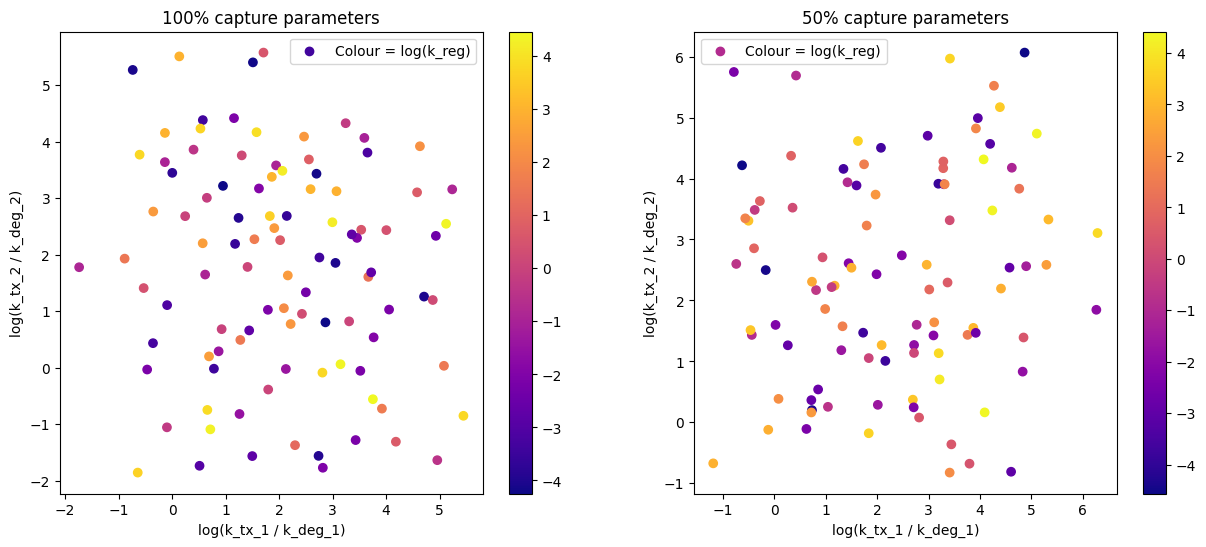

In [447]:
# select set
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

params = params_high_revised
sc1 = axs[0].scatter(
    np.log(params['k_tx_1']) - np.log(params['k_deg_1']),
    np.log(params['k_tx_2']) - np.log(params['k_deg_2']),
    c=np.log(params['k_reg']),
    label="Colour = log(k_reg)",
    cmap=plt.cm.plasma
)
params = params_med_revised
sc2 = axs[1].scatter(
    np.log(params['k_tx_1']) - np.log(params['k_deg_1']),
    np.log(params['k_tx_2']) - np.log(params['k_deg_2']),
    c=np.log(params['k_reg']),
    label="Colour = log(k_reg)",
    cmap=plt.cm.plasma
)
plt.colorbar(sc1)
plt.colorbar(sc2)
axs[0].set_xlabel("log(k_tx_1 / k_deg_1)")
axs[0].set_ylabel("log(k_tx_2 / k_deg_2)")
axs[0].set_title(f"100% capture parameters")
axs[0].legend()
axs[1].set_xlabel("log(k_tx_1 / k_deg_1)")
axs[1].set_ylabel("log(k_tx_2 / k_deg_2)")
axs[1].set_title(f"50% capture parameters")
axs[1].legend()
plt.show()

Points are plotted with x, y as the log-mean of each gene as if it followed an independent (no interaction) poisson distrituion, this location gives some indication as to the mean (original) expression level. Points are coloured according to the regulation (interaction) parameter

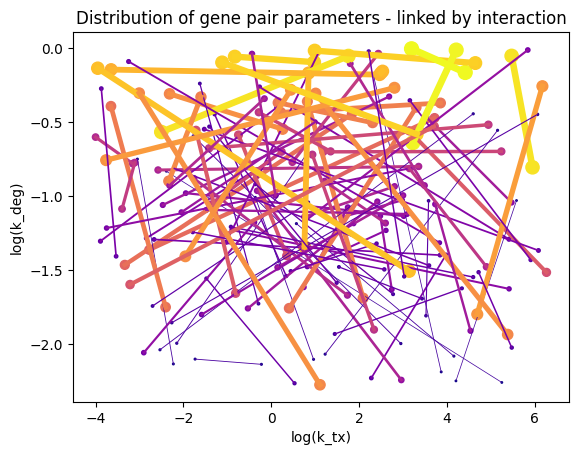

In [11]:
# select set
params = params_low

# scatter
plt.scatter(
    np.log(params['k_tx_1']),
    np.log(params['k_deg_1']),
    s=params['k_reg']**2,
    c=params['k_reg'],
    cmap=plt.cm.plasma
)
plt.scatter(
    np.log(params['k_tx_2']),
    np.log(params['k_deg_2']),
    s=params['k_reg']**2,
    c=params['k_reg'],
    cmap=plt.cm.plasma
)

for i in range(100):
    param_set = params.loc[f'Gene-pair-{i}']
    col = plt.cm.plasma(0.1 * param_set['k_reg'])
    plt.plot(
        [np.log(param_set['k_tx_1']), np.log(param_set['k_tx_2'])],
        [np.log(param_set['k_deg_1']), np.log(param_set['k_deg_2'])],
        color=col,
        linewidth=0.5 * param_set['k_reg']
    )

plt.xlabel("log(k_tx)")
plt.ylabel("log(k_deg)")
plt.title("Distribution of gene pair parameters - linked by interaction")
#plt.legend()
plt.show()

For each pair of interacting genes we plot 2 points with x, y = log of tx and deg rates and join them by a line to indicate their interaction. The colour and size of the points + line are determined by the magnitude of the interaction rate, with higher values being brighter and thicker.

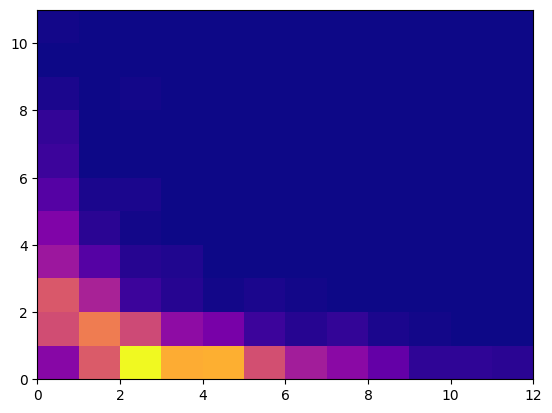

In [12]:
# select sample
counts = counts_high
i = 24

sample = list(counts.loc[f'Gene-pair-{i}'])
x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]

# plot dist
plt.hist2d(x1_sample, x2_sample, 
           bins=[range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2)],
           cmap='plasma');

A simple 2D histogram (/heatmap, etc) shows the distribution of counts (x1, x2) for a pair of interacting genes

# Dataset Analysis

## Setup

In [265]:
# pre-compute truncations for a given capture efficiency
truncations_high = preComputeTruncation(100, 100, beta_high, 10**-6)
truncations_med = preComputeTruncation(100, 100, beta_med, 10**-6)
truncations_low = preComputeTruncation(30, 30, beta_low, 10**-6)

### Plotting code

In [ ]:
def scatter_results(params_data, solution_dict, marker="o", show=True, scale=True, interaction=True, mtype="hyp"):
    '''
    Scatter plot of gene-pair parameters, coloured by interaction detection and
    optionally scaled by interaction strength

    params_data: dataset of true gene-pair parameters
    solution_dict: dictionary of gene-pair indices and their optimization / correlation test solutions

    marker: choice of scatterplot point marker
    show: toggle showing plot
    scale: toggle if point size is scaled by true interaction strength
    interaction: toggle if data has interaction (to colour points correctly)
    mtype: type of method used for results: "hyp", "min" or "corr"
    '''

    rates_1 = []
    rates_2 = []
    color = []

    # flag for single label
    green_label_needed = True
    red_label_needed = True
    blue_label_needed = True

    # loop over solutions
    for key, val in solution_dict.items():

        # access true parameters
        params = params_data.loc[f'Gene-pair-{key}']

        # reset plot label
        label = None

        # decide if interaction was detected
        if mtype == "hyp":
            if val == 'INFEASIBLE':
                detected = True
            elif val == 'OPTIMAL':
                detected = False
            else:
                detected = None
        elif mtype == "min":
            if val[1] == 'USER_OBJ_LIMIT':
                detected = True
            elif (val[1] == 'OPTIMAL') and (val[0] > 0.0001) and (val[0] < np.inf):
                detected = True
            elif val[1] == 'OPTIMAL':
                detected = False
            else:
                detected = None
        else:
            if val[1] < 0.05:
                detected = True
            elif val[1] >= 0.05:
                detected = False
            else:
                detected = None

        # set colour according to detection of interaction: data has interaction
        if interaction:
            if detected == True:
                color = "green"
                if green_label_needed:
                    label = "Interaction detected"
                    green_label_needed = False
            elif detected == False:
                color = "red"
                if red_label_needed:
                    label = "Interaction not detected"
                    red_label_needed = False
            else:
                color = "blue"
                if blue_label_needed:
                    if mtype == "corr":
                        label="Undefined"
                    else:
                        label="Time limit"
                    blue_label_needed = False

        # set colour according to detection of interaction: data has no interaction
        else:
            if detected == False:
                color = "green"
                if green_label_needed:
                    label = "True negative"
                    green_label_needed = False
            elif detected == True:
                color = "red"
                if red_label_needed:
                    label = "False positive"
                    red_label_needed = False
            else:
                color = "blue"
                if blue_label_needed:
                    if mtype == "corr":
                        label = "Undefined"
                    else:
                        label="Time limit"
                    blue_label_needed = False
        
        # plot point: (x, y) location as log-mean of genes, colour (and size) as interaction strength
        if scale:
            s = params['k_reg'] * 10
        else:
            s = None
        plt.scatter(np.log(params['k_tx_1']) - np.log(params['k_deg_1']), np.log(params['k_tx_2']) - np.log(params['k_deg_2']),
                    s=s, color=color, label=label, marker=marker)

    plt.xlabel("log(k_tx_1 / k_deg_1)")
    plt.ylabel("log(k_tx_2 / k_deg_2)")
    plt.title("Distribution of parameters and detection")
    plt.legend()
    if show: plt.show()

### Classification metrics code

In [313]:
def classification_metrics(params_data, solution_dict, interaction=True, mtype="hyp", n=100):
    '''
    Compute classification metrics for interaction detection

    params_data: dataset of true gene-pair parameters
    solution_dict: dictionary of gene-pair indices and their optimization / correlation test solutions

    interaction: toggle if data has interaction (to colour points correctly)
    mtype: type of method used for results: "hyp", "min" or "corr"
    '''
    metrics = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}

    for key, val in solution_dict.items():

        # access true parameters
        params = params_data.loc[f'Gene-pair-{key}']

        # truth
        if (params['k_reg'] == 0):
            # negative (no interaction)
            truth = 0
        else:
            # positive (interaction)
            truth = 1

        # prediction
        if mtype == "hyp":
            if val == 'INFEASIBLE':
                # positive predicted (interaction detected)
                pred = 1
            else:
                # negative predicted (interaction not detected) [include time limit, etc.]
                pred = 0

        elif mtype == "min":
            # positive predicted (interaction detected)
            if val[1] == 'USER_OBJ_LIMIT':
                pred = 1
            elif (val[1]== 'OPTIMAL') and (val[0] > 0.0001) and (val[0] < np.inf):
                pred = 1
            # negative predicted (interaction not detected) [include infeasible, time limit, etc.]
            else:
                pred = 0
                
        else:
            if val[1] < 0.05:
                # positive predicted (interaction detected)
                pred = 1
            else:
                # negative predicted (interaction not detected) [include nan, etc.]
                pred = 0

        
        # store result
        if truth == 1:
            if pred == 1:
                metrics['TP'] += 1 / n
            else:
                metrics['FN'] += 1 / n
        else:
            if pred == 1:
                metrics['FP'] += 1 / n
            else:
                metrics['TN'] += 1 / n

    return metrics

In [222]:
def add_metrics(metrics_1, metrics_2):
    return {key: (metrics_1[key] + metrics_2[key]) / 2 for key in ['TP', 'FP', 'FN', 'TN']}

In [359]:
def display_metrics(metrics):

    # compute measures
    accuracy = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
    precision = metrics['TP'] / (metrics['TP'] + metrics['FP'])
    recall = metrics['TP'] / (metrics['TP'] + metrics['FN'])
    F1_score = 2 * (precision * recall) / (precision + recall)

    # print measures
    print(f"accuracy = {round(accuracy, 2)}")
    print(f"precision = {round(precision, 2)}")
    print(f"recall = {round(recall, 2)}")
    print(f"F1 score = {round(F1_score, 2)}")

    # display confusion matrix
    values = [[metrics['TP'], metrics['FP']], [metrics['FN'], metrics['TN']]]
    confusion_matrix = pd.DataFrame(data=values, index=['Predicted Positive', 'Predicted Negative'], columns=['Positive', 'Negative'])
    cm = sns.light_palette("blue", as_cmap=True)
    return confusion_matrix.style.format(precision=2).background_gradient(cmap=cm, axis=None)

In [336]:
def result_to_display(params, solutions, params_noInt, solutions_noInt, mtype="hyp"):

    metrics = classification_metrics(params, solutions, mtype=mtype)
    metrics_noInt = classification_metrics(params_noInt, solutions_noInt, mtype=mtype, interaction=False)
    metrics_combined = add_metrics(metrics, metrics_noInt)
    return display_metrics(metrics_combined)

In [ ]:
def proxy(params):
    log_mean_1 = np.log(params['k_tx_1']) - np.log(params['k_deg_1'])
    log_mean_2 = np.log(params['k_tx_2']) - np.log(params['k_deg_2'])
    log_int_str = float(np.log(params['k_reg']))
    proxy = float((log_mean_1 + log_mean_2) / 2)
    decision = bool(proxy > log_int_str)
    return decision, proxy, log_int_str

In [188]:
confusion_matrix = pd.DataFrame(data=[[0, 0], [0, 0]], index=['Detected', 'Not Detected'], columns=['Proxy', 'Not Proxy'])

for key, val in solution_dict_med_revised.items():

    param_set = params_med_revised.loc[f'Gene-pair-{key}']

    int_str = np.log(param_set['k_reg'])
    log_mean_1 = np.log(param_set['k_tx_1']) - np.log(param_set['k_deg_1'])
    log_mean_2 = np.log(param_set['k_tx_2']) - np.log(param_set['k_deg_2'])
    proxy = (log_mean_1 + log_mean_2) / 2
    result = solution_dict_med_revised[key]

    if result == 'INFEASIBLE':
        ind = 'Detected'
    else:
        ind = 'Not Detected'
    if proxy > int_str:
        col = 'Proxy'
    else:
        col = 'Not Proxy'

    confusion_matrix.loc[ind, col] += 1

confusion_matrix


,Proxy,Not Proxy
Detected,60,20
Not Detected,16,4


## Original Datasets

In [36]:
'''high dataset'''

# store results
solution_dict_high_all = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    # optimize
    solution = optimization_B_hyp(bounds, beta_high, truncations_high, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=300)

    # store result
    solution_dict_high_all[i] = solution['status']

Observed counts: [5, 22] x [0, 0] 
Original counts: [0, 22] x [0, 0]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [93, 126] x [0, 0] 
Original counts: [0, 126] x [0, 0]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 0] x [14, 33] 
Original counts: [0, 0] x [0, 33]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [61, 94] x [0, 0] 
Original counts: [0, 94] x [0, 0]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 0] x [0, 6] 
Original counts: [0, 0] x [0, 6]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 0] x [0, 10] 
Original counts: [0, 0] x [0, 10]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 1] x [0, 0] 
Original counts: [0, 1] x [0, 0]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Obser

In [15]:
'''med dataset'''

# store results
solution_dict_med = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
        continue
    
    # optimize
    solution = optimization_B_hyp(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=300)

    # store result
    solution_dict_med[i] = solution['status']

Observed counts: [0, 1] x [0, 1] 
Original counts: [0, 13] x [0, 13]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 1] x [0, 1] 
Original counts: [0, 13] x [0, 13]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 1] x [0, 1] 
Original counts: [0, 13] x [0, 13]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 1] x [0, 1] 
Original counts: [0, 13] x [0, 13]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 2] x [0, 3] 
Original counts: [0, 18] x [0, 19]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 6] x [0, 1] 
Original counts: [0, 22] x [0, 17]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1
Observed counts: [0, 1] x [0, 1] 
Original counts: [0, 13] x [0, 13]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1


In [69]:
'''low dataset'''

# store results
solution_dict_low = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_low.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
        continue

    print(f"\n{i}:\n")
    
    # optimize
    solution = optimization_B_hyp(bounds, beta_low, truncations_low, K=100, silent=False,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=1200)

    # store result
    solution_dict_low[i] = solution['status']


33:

Set parameter TimeLimit to value 1200
Observed counts: [0, 4] x [0, 1] 
Original counts: [0, 187] x [0, 184]
Set parameter Presolve to value 2
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 35157 columns and 375 nonzeros
Model fingerprint: 0x7ffed2c1
Model has 69208 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-10, 2e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+00]
  QRHS range       [8e-03, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2 r

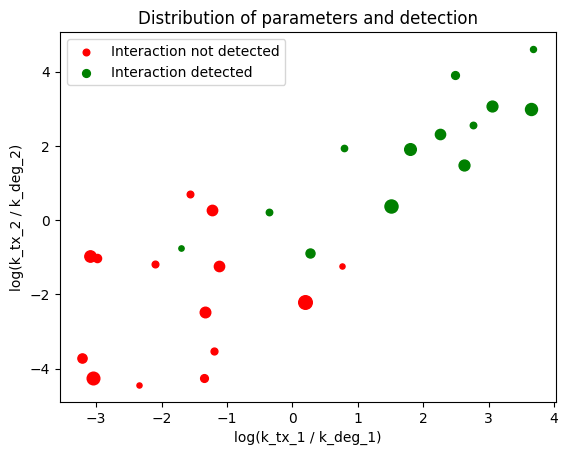

In [157]:
scatter_results(params_high, solution_dict_high)

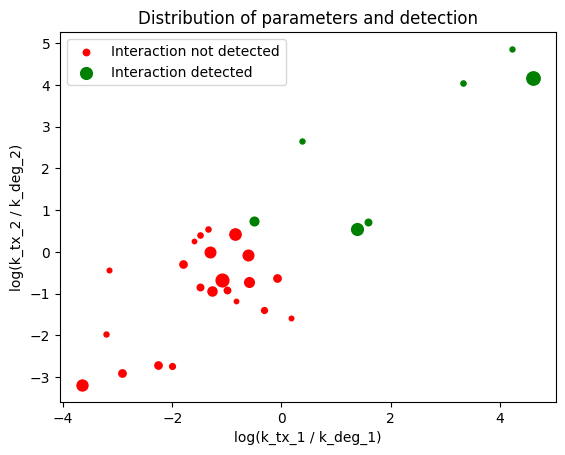

In [158]:
scatter_results(params_med, solution_dict_med)

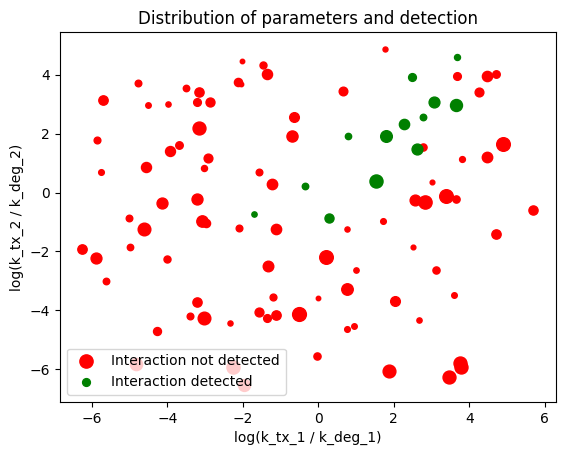

In [159]:
scatter_results(params_high, solution_dict_high_all)

## Revised Datasets

### Hypothesis tests

In [94]:
'''high dataset'''

# store results
solution_dict_high_revised = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high_revised.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_B_hyp(bounds, beta_high, truncations_high, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=300)

    # store result
    solution_dict_high_revised[i] = solution['status']


0:

Observed counts: [0, 1] x [62, 88] 
Original counts: [0, 1] x [0, 88]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

1:

Observed counts: [39, 76] x [0, 0] 
Original counts: [0, 76] x [0, 0]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

2:

Observed counts: [0, 3] x [8, 19] 
Original counts: [0, 3] x [0, 19]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

3:

Observed counts: [0, 9] x [0, 1] 
Original counts: [0, 9] x [0, 1]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

4:

Observed counts: [0, 0] x [197, 237] 
Original counts: [0, 0] x [0, 237]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

5:

Observed counts: [3, 11] x [3, 9] 
Original counts: [0, 11] x [0, 9]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

6:

Observed counts: [0, 2] x [0, 3] 
Original counts: [0, 2] x [0, 3]
Model is OPTIMAL
k_tx_1 variable
k_t

In [131]:
'''high dataset: no interaction'''

# store results
solution_dict_high_revised_noInt = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high_revised_noInt.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_B_hyp(bounds, beta_high, truncations_high, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=300)

    # store result
    solution_dict_high_revised_noInt[i] = solution['status']


0:

Observed counts: [11, 28] x [0, 1] 
Original counts: [0, 28] x [0, 1]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

1:

Observed counts: [151, 162] x [2, 3] 
Original counts: [0, 162] x [0, 3]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

2:

Observed counts: [4, 15] x [0, 2] 
Original counts: [0, 15] x [0, 2]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

3:

Observed counts: [0, 3] x [26, 43] 
Original counts: [0, 3] x [0, 43]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

4:

Observed counts: [144, 156] x [3, 4] 
Original counts: [0, 156] x [0, 4]
Model is TIME_LIMIT
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

5:

Observed counts: [16, 27] x [2, 6] 
Original counts: [0, 27] x [0, 6]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

6:

Observed counts: [3, 8] x [20, 31] 
Original counts: [0, 8] x [0, 31]
Model is OPTIMAL
k_tx_1 varia

In [124]:
'''med dataset'''

# store results
solution_dict_med_revised = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_B_hyp(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=300)

    # store result
    solution_dict_med_revised[i] = solution['status']


0:

Observed counts: [0, 1] x [14, 32] 
Original counts: [0, 21] x [0, 42]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

1:

Observed counts: [0, 4] x [0, 2] 
Original counts: [0, 20] x [0, 18]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

2:

Observed counts: [0, 0] x [3, 15] 
Original counts: [0, 17] x [0, 32]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

3:

Observed counts: [0, 8] x [0, 3] 
Original counts: [0, 28] x [0, 23]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

4:

Observed counts: [2, 8] x [10, 18] 
Original counts: [0, 39] x [0, 48]
Model is TIME_LIMIT
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

5:

Observed counts: [0, 4] x [0, 4] 
Original counts: [0, 23] x [0, 23]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

6:

Observed counts: [0, 0] x [25, 49] 
Original counts: [0, 0] x [0, 49]
Model is INFEASIBLE
k_t

In [143]:
'''med dataset: no interaction'''

# store results
solution_dict_med_revised_noInt = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised_noInt.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_B_hyp(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        time_limit=300)

    # store result
    solution_dict_med_revised_noInt[i] = solution['status']


0:

Observed counts: [0, 2] x [2, 12] 
Original counts: [0, 23] x [0, 33]
Model is TIME_LIMIT
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

1:

Observed counts: [7, 13] x [14, 21] 
Original counts: [0, 44] x [0, 48]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

2:

Observed counts: [49, 75] x [0, 1] 
Original counts: [0, 75] x [0, 1]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

3:

Observed counts: [0, 4] x [0, 5] 
Original counts: [0, 24] x [0, 25]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

4:

Observed counts: [24, 30] x [18, 22] 
Original counts: [0, 30] x [0, 22]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

5:

Observed counts: [0, 2] x [0, 5] 
Original counts: [0, 19] x [0, 22]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1

6:

Observed counts: [5, 14] x [0, 4] 
Original counts: [0, 39] x [0, 29]
Model is TIME_LIMIT
k_

### Minimization tests

In [252]:
'''high dataset'''

# store results
solution_dict_high_revised_min = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high_revised.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_min(bounds, beta_high, truncations_high, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

    # store result
    solution_dict_high_revised_min[i] = solution['k_reg']


0:

Observed counts: [0, 1] x [62, 88] 
Original counts: [0, 1] x [0, 88]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

1:

Observed counts: [39, 76] x [0, 0] 
Original counts: [0, 76] x [0, 0]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

2:

Observed counts: [0, 3] x [8, 19] 
Original counts: [0, 3] x [0, 19]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg non-zero lower bound found, early termination status USER_OBJ_LIMIT

3:

Observed counts: [0, 9] x [0, 1] 
Original counts: [0, 9] x [0, 1]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 1.6504777031471178e-09, status OPTIMAL

4:

Observed counts: [0, 0] x [197, 237] 
Original counts: [0, 0] x [0, 

In [254]:
'''high dataset: no interaction'''

# store results
solution_dict_high_revised_min_noInt = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high_revised_noInt.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_min(bounds, beta_high, truncations_high, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

    # store result
    solution_dict_high_revised_min_noInt[i] = solution['k_reg']


0:

Observed counts: [11, 28] x [0, 1] 
Original counts: [0, 28] x [0, 1]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 1.6505019739659256e-09, status OPTIMAL

1:

Observed counts: [151, 162] x [2, 3] 
Original counts: [0, 162] x [0, 3]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

2:

Observed counts: [4, 15] x [0, 2] 
Original counts: [0, 15] x [0, 2]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 1.6504762328975564e-09, status OPTIMAL

3:

Observed counts: [0, 3] x [26, 43] 
Original counts: [0, 3] x [0, 43]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

4:

Observed counts: [144, 156] x [3, 4] 
Original counts: [0, 156] x [0, 4]
k_tx_1

In [274]:
'''med dataset'''

# store results
solution_dict_med_revised_min = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_min(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

    # store result
    solution_dict_med_revised_min[i] = solution['k_reg']


0:

Observed counts: [0, 1] x [14, 32] 
Original counts: [0, 21] x [0, 42]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound None, status INFEASIBLE

1:

Observed counts: [0, 4] x [0, 2] 
Original counts: [0, 20] x [0, 18]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound inf, status TIME_LIMIT

2:

Observed counts: [0, 0] x [3, 15] 
Original counts: [0, 17] x [0, 32]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg non-zero lower bound found, early termination status USER_OBJ_LIMIT

3:

Observed counts: [0, 8] x [0, 3] 
Original counts: [0, 28] x [0, 23]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg non-zero lower bound found, early termination status USER_OBJ_LIMIT

4:

Observed counts: [2, 8] x [10, 18] 
Origi

In [275]:
'''med dataset: no interaction'''

# store results
solution_dict_med_revised_min_noInt = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised_noInt.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_min(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

    # store result
    solution_dict_med_revised_min_noInt[i] = solution['k_reg']


0:

Observed counts: [0, 2] x [2, 12] 
Original counts: [0, 23] x [0, 33]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound inf, status TIME_LIMIT

1:

Observed counts: [7, 13] x [14, 21] 
Original counts: [0, 44] x [0, 48]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound None, status INFEASIBLE

2:

Observed counts: [49, 75] x [0, 1] 
Original counts: [0, 75] x [0, 1]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound None, status INFEASIBLE

3:

Observed counts: [0, 4] x [0, 5] 
Original counts: [0, 24] x [0, 25]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

4:

Observed counts: [24, 30] x [18, 22] 
Original counts: [0, 30] x [0, 22]
k_tx_1 variable, not optimized
k_t

In [350]:
'''med dataset: 10 minute time limit'''

# store results
solution_dict_med_revised_min_long = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_min(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        MIPGap=0.05, time_limit=600, BestBdThresh=0.0001)

    # store result
    solution_dict_med_revised_min_long[i] = solution['k_reg']


0:

Observed counts: [0, 1] x [14, 32] 
Original counts: [0, 21] x [0, 42]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound None, status INFEASIBLE

1:

Observed counts: [0, 4] x [0, 2] 
Original counts: [0, 20] x [0, 18]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

2:

Observed counts: [0, 0] x [3, 15] 
Original counts: [0, 17] x [0, 32]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg non-zero lower bound found, early termination status USER_OBJ_LIMIT

3:

Observed counts: [0, 8] x [0, 3] 
Original counts: [0, 28] x [0, 23]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg non-zero lower bound found, early termination status USER_OBJ_LIMIT

4:

Observed counts: [2, 8] x [10, 18] 
Original

In [351]:
'''med dataset: no interaction + 10 minute time limit'''

# store results
solution_dict_med_revised_min_noInt_long = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised_noInt.loc[f'Gene-pair-{i}'])

    # bootstrap
    bounds = bootstrap_data(samples, BS=1000, thresh=10, printing=False)

    # if one gene only produces observed counts of 0: skip
    #if (bounds['M_OB'] == 0) or (bounds['N_OB'] == 0):
    #    continue
    
    print(f"\n{i}:\n")

    # optimize
    solution = optimization_min(bounds, beta_med, truncations_med, K=100, silent=True,
                        print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                        MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

    # store result
    solution_dict_med_revised_min_noInt_long[i] = solution['k_reg']


0:

Observed counts: [0, 2] x [2, 12] 
Original counts: [0, 23] x [0, 33]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound inf, status TIME_LIMIT

1:

Observed counts: [7, 13] x [14, 21] 
Original counts: [0, 44] x [0, 48]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound None, status INFEASIBLE

2:

Observed counts: [49, 75] x [0, 1] 
Original counts: [0, 75] x [0, 1]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound None, status INFEASIBLE

3:

Observed counts: [0, 4] x [0, 5] 
Original counts: [0, 24] x [0, 25]
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg lower bound 0.0, status OPTIMAL

4:

Observed counts: [24, 30] x [18, 22] 
Original counts: [0, 30] x [0, 22]
k_tx_1 variable, not optimized
k_t

### Correlation tests

In [319]:
'''high dataset'''

# store results
solution_dict_high_revised_pearson = {}
solution_dict_high_revised_spearman = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high_revised.loc[f'Gene-pair-{i}'])

    x1_samples = [x[0] for x in samples]
    x2_samples = [x[1] for x in samples]

    # test
    pearson = scipy.stats.pearsonr(x1_samples, x2_samples)
    spearman = scipy.stats.spearmanr(x1_samples, x2_samples)

    # store result
    solution_dict_high_revised_pearson[i] = [float(pearson.statistic), float(pearson.pvalue)]
    solution_dict_high_revised_spearman[i] = [float(spearman.statistic), float(spearman.pvalue)]

C:\Users\willi\AppData\Local\Temp\ipykernel_22580\550513777.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = scipy.stats.pearsonr(x1_samples, x2_samples)
C:\Users\willi\AppData\Local\Temp\ipykernel_22580\550513777.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = scipy.stats.spearmanr(x1_samples, x2_samples)


In [327]:
'''high dataset: no interaction'''

# store results
solution_dict_high_revised_pearson_noInt = {}
solution_dict_high_revised_spearman_noInt = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_high_revised_noInt.loc[f'Gene-pair-{i}'])

    x1_samples = [x[0] for x in samples]
    x2_samples = [x[1] for x in samples]

    # test
    pearson = scipy.stats.pearsonr(x1_samples, x2_samples)
    spearman = scipy.stats.spearmanr(x1_samples, x2_samples)

    # store result
    solution_dict_high_revised_pearson_noInt[i] = [float(pearson.statistic), float(pearson.pvalue)]
    solution_dict_high_revised_spearman_noInt[i] = [float(spearman.statistic), float(spearman.pvalue)]

In [321]:
'''med dataset'''

# store results
solution_dict_med_revised_pearson = {}
solution_dict_med_revised_spearman = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised.loc[f'Gene-pair-{i}'])

    x1_samples = [x[0] for x in samples]
    x2_samples = [x[1] for x in samples]

    # test
    pearson = scipy.stats.pearsonr(x1_samples, x2_samples)
    spearman = scipy.stats.spearmanr(x1_samples, x2_samples)

    # store result
    solution_dict_med_revised_pearson[i] = [float(pearson.statistic), float(pearson.pvalue)]
    solution_dict_med_revised_spearman[i] = [float(spearman.statistic), float(spearman.pvalue)]

C:\Users\willi\AppData\Local\Temp\ipykernel_22580\3307810710.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = scipy.stats.pearsonr(x1_samples, x2_samples)
C:\Users\willi\AppData\Local\Temp\ipykernel_22580\3307810710.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = scipy.stats.spearmanr(x1_samples, x2_samples)


In [328]:
'''med dataset: no interaction'''

# store results
solution_dict_med_revised_pearson_noInt = {}
solution_dict_med_revised_spearman_noInt = {}

# loop over genes
for i in range(100):

    # select sample
    samples = list(counts_med_revised_noInt.loc[f'Gene-pair-{i}'])

    x1_samples = [x[0] for x in samples]
    x2_samples = [x[1] for x in samples]

    # test
    pearson = scipy.stats.pearsonr(x1_samples, x2_samples)
    spearman = scipy.stats.spearmanr(x1_samples, x2_samples)

    # store result
    solution_dict_med_revised_pearson_noInt[i] = [float(pearson.statistic), float(pearson.pvalue)]
    solution_dict_med_revised_spearman_noInt[i] = [float(spearman.statistic), float(spearman.pvalue)]

## Results: Store

In [ ]:
'''
# high cap eff
json.dump(solution_dict_high_revised, open(".\Revised-Results\solution_dict_high_revised.json", 'w'))
json.dump(solution_dict_high_revised_min, open(".\Revised-Results\solution_dict_high_revised_min.json", 'w'))
json.dump(solution_dict_high_revised_pearson, open(".\Revised-Results\solution_dict_high_revised_pearson.json", 'w'))
json.dump(solution_dict_high_revised_spearman, open(".\Revised-Results\solution_dict_high_revised_spearman.json", 'w'))

# high cap eff no interaction
json.dump(solution_dict_high_revised_noInt, open(".\Revised-Results\solution_dict_high_revised_noInt.json", 'w'))
json.dump(solution_dict_high_revised_min_noInt, open(".\Revised-Results\solution_dict_high_revised_min_noInt.json", 'w'))
json.dump(solution_dict_high_revised_pearson_noInt, open(".\Revised-Results\solution_dict_high_revised_pearson_noInt.json", 'w'))
json.dump(solution_dict_high_revised_spearman_noInt, open(".\Revised-Results\solution_dict_high_revised_spearman_noInt.json", 'w'))

# med cap eff
json.dump(solution_dict_med_revised, open(".\Revised-Results\solution_dict_med_revised.json", 'w'))
json.dump(solution_dict_med_revised_min, open(".\Revised-Results\solution_dict_med_revised_min.json", 'w'))
json.dump(solution_dict_med_revised_pearson, open(".\Revised-Results\solution_dict_med_revised_pearson.json", 'w'))
json.dump(solution_dict_med_revised_spearman, open(".\Revised-Results\solution_dict_med_revised_spearman.json", 'w'))

# med cap eff no interaction
json.dump(solution_dict_med_revised_noInt, open(".\Revised-Results\solution_dict_med_revised_noInt.json", 'w'))
json.dump(solution_dict_med_revised_min_noInt, open(".\Revised-Results\solution_dict_med_revised_min_noInt.json", 'w'))
json.dump(solution_dict_med_revised_pearson_noInt, open(".\Revised-Results\solution_dict_med_revised_pearson_noInt.json", 'w'))
json.dump(solution_dict_med_revised_spearman_noInt, open(".\Revised-Results\solution_dict_med_revised_spearman_noInt.json", 'w'))
'''

## Results: Plots

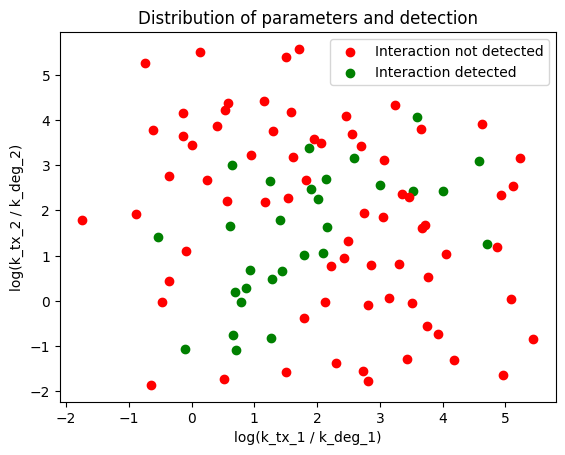

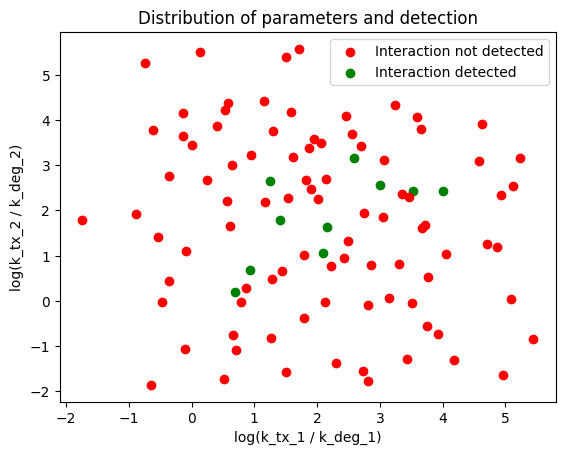

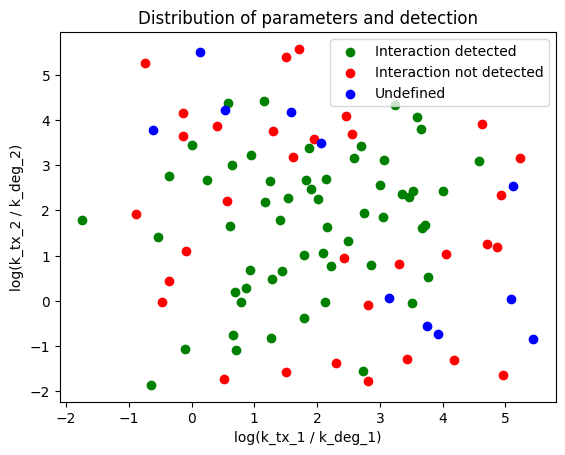

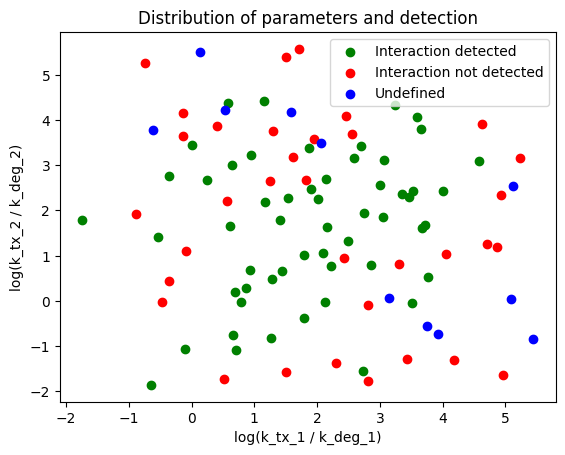

In [329]:
scatter_results(params_high_revised, solution_dict_high_revised, scale=False, mtype="hyp")
scatter_results(params_high_revised, solution_dict_high_revised_min, scale=False, mtype="min")
scatter_results(params_high_revised, solution_dict_high_revised_pearson, scale=False, mtype="corr")
scatter_results(params_high_revised, solution_dict_high_revised_spearman, scale=False, mtype="corr")

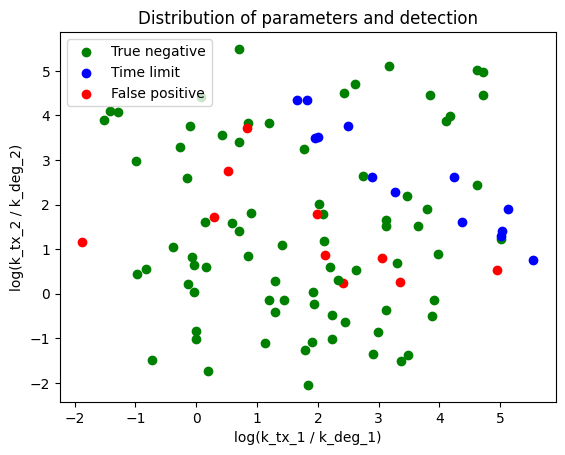

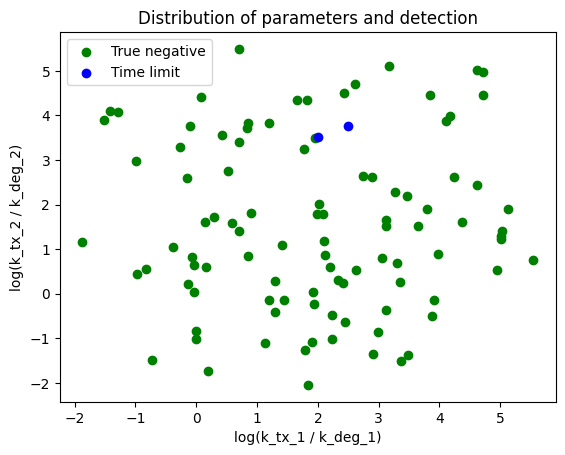

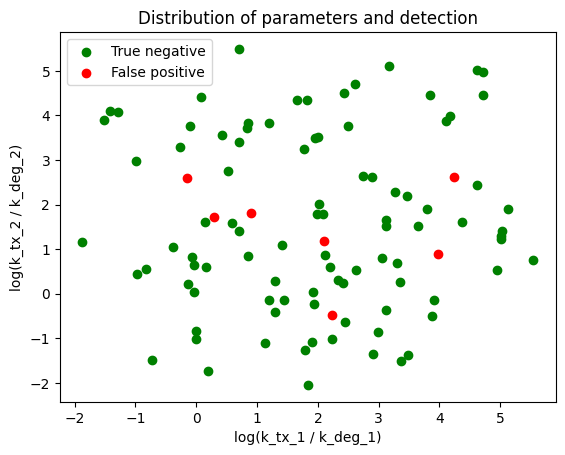

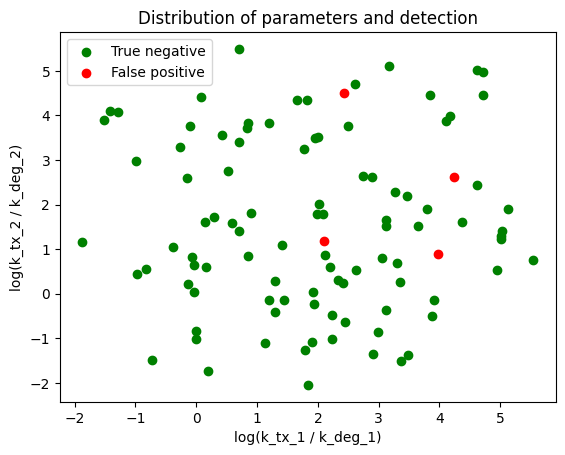

In [330]:
scatter_results(params_high_revised_noInt, solution_dict_high_revised_noInt, scale=False, mtype="hyp", interaction=False)
scatter_results(params_high_revised_noInt, solution_dict_high_revised_min_noInt, scale=False, mtype="min", interaction=False)
scatter_results(params_high_revised_noInt, solution_dict_high_revised_pearson_noInt, scale=False, mtype="corr", interaction=False)
scatter_results(params_high_revised_noInt, solution_dict_high_revised_spearman_noInt, scale=False, mtype="corr", interaction=False)

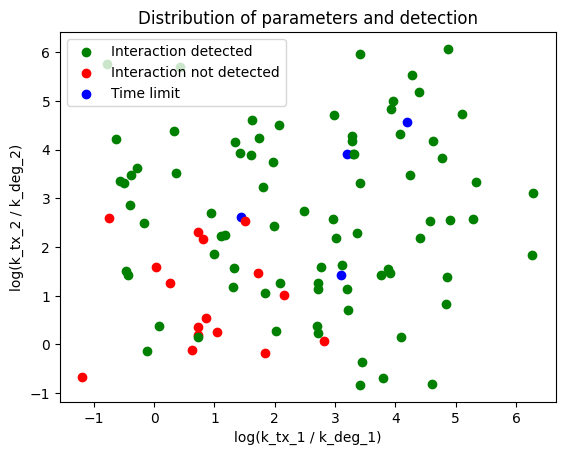

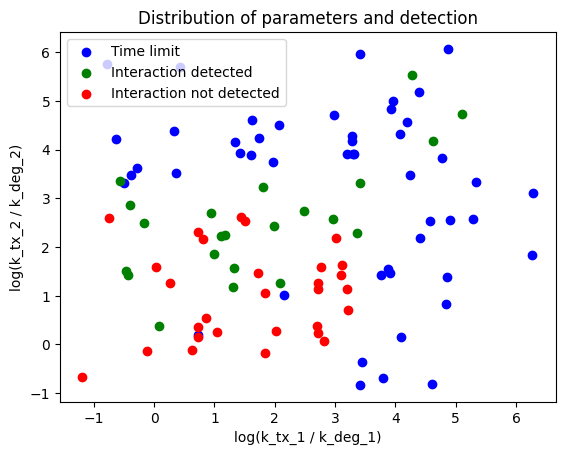

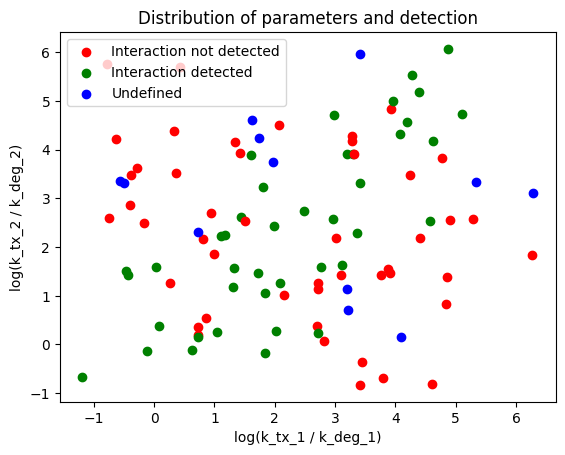

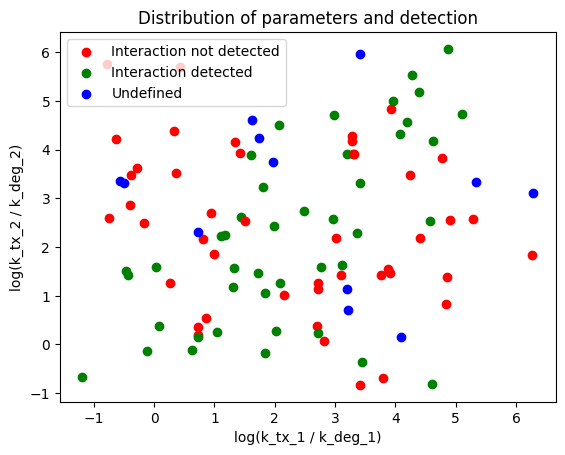

In [331]:
scatter_results(params_med_revised, solution_dict_med_revised, scale=False, mtype="hyp")
scatter_results(params_med_revised, solution_dict_med_revised_min, scale=False, mtype="min")
scatter_results(params_med_revised, solution_dict_med_revised_pearson, scale=False, mtype="corr")
scatter_results(params_med_revised, solution_dict_med_revised_spearman, scale=False, mtype="corr")

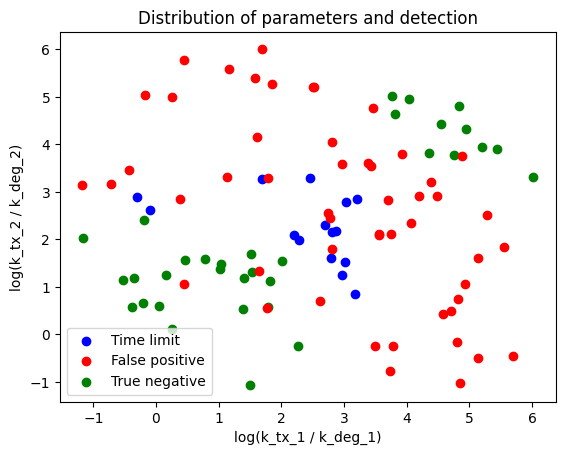

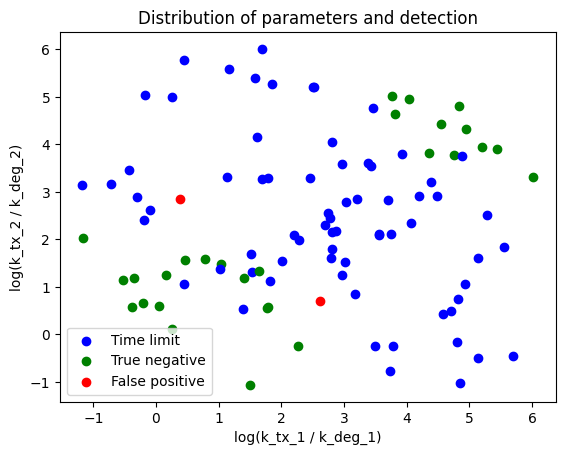

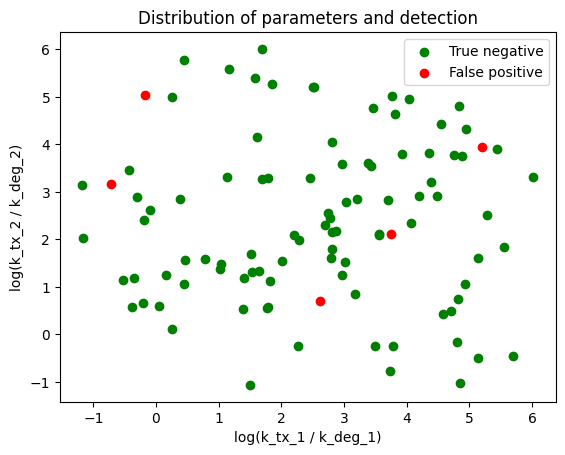

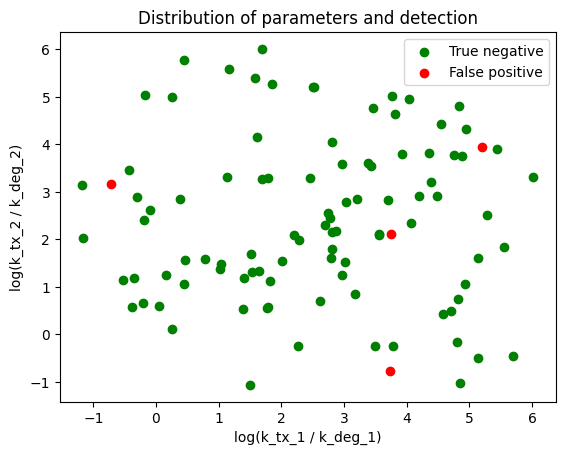

In [332]:
scatter_results(params_med_revised_noInt, solution_dict_med_revised_noInt, scale=False, mtype="hyp", interaction=False)
scatter_results(params_med_revised_noInt, solution_dict_med_revised_min_noInt, scale=False, mtype="min", interaction=False)
scatter_results(params_med_revised_noInt, solution_dict_med_revised_pearson_noInt, scale=False, mtype="corr", interaction=False)
scatter_results(params_med_revised_noInt, solution_dict_med_revised_spearman_noInt, scale=False, mtype="corr", interaction=False)

## Results: Metrics

In [360]:
# high cap eff, hyp
result_to_display(params_high_revised, solution_dict_high_revised, params_high_revised_noInt, solution_dict_high_revised_noInt, mtype="hyp")

accuracy = 0.6
precision = 0.74
recall = 0.29
F1 score = 0.42


,Positive,Negative
Predicted Positive,0.15,0.05
Predicted Negative,0.36,0.45


In [361]:
# high cap eff, min
result_to_display(params_high_revised, solution_dict_high_revised_min, params_high_revised_noInt, solution_dict_high_revised_min_noInt, mtype="min")

accuracy = 0.55
precision = 1.0
recall = 0.1
F1 score = 0.18


,Positive,Negative
Predicted Positive,0.05,0.00
Predicted Negative,0.45,0.50


In [362]:
# high cap eff, pearson
result_to_display(params_high_revised, solution_dict_high_revised_pearson, params_high_revised_noInt, solution_dict_high_revised_pearson_noInt, mtype="corr")

accuracy = 0.75
precision = 0.89
recall = 0.57
F1 score = 0.7


,Positive,Negative
Predicted Positive,0.29,0.04
Predicted Negative,0.22,0.47


In [363]:
# high cap eff, spearman
result_to_display(params_high_revised, solution_dict_high_revised_spearman, params_high_revised_noInt, solution_dict_high_revised_spearman_noInt, mtype="corr")

accuracy = 0.75
precision = 0.93
recall = 0.55
F1 score = 0.69


,Positive,Negative
Predicted Positive,0.28,0.02
Predicted Negative,0.23,0.48


In [364]:
# med cap eff, hyp
print("hyp, 50% cap eff\n")
result_to_display(params_med_revised, solution_dict_med_revised, params_med_revised_noInt, solution_dict_med_revised_noInt, mtype="hyp")

hyp, 50% cap eff

accuracy = 0.64
precision = 0.61
recall = 0.8
F1 score = 0.69


,Positive,Negative
Predicted Positive,0.40,0.26
Predicted Negative,0.10,0.24


In [365]:
# med cap eff, min
print("min, 50% cap eff\n")
result_to_display(params_med_revised, solution_dict_med_revised_min, params_med_revised_noInt, solution_dict_med_revised_min_noInt, mtype="min")

min, 50% cap eff

accuracy = 0.6
precision = 0.92
recall = 0.22
F1 score = 0.35


,Positive,Negative
Predicted Positive,0.11,0.01
Predicted Negative,0.39,0.49


In [368]:
# med cap eff, pearson
print("corr, 50% cap eff\n")
result_to_display(params_med_revised, solution_dict_med_revised_pearson, params_med_revised_noInt, solution_dict_med_revised_pearson_noInt, mtype="corr")

corr, 50% cap eff

accuracy = 0.68
precision = 0.89
recall = 0.41
F1 score = 0.56


,Positive,Negative
Predicted Positive,0.21,0.03
Predicted Negative,0.30,0.48


In [367]:
# med cap eff, spearman
print("corr, 50% cap eff\n")
result_to_display(params_med_revised, solution_dict_med_revised_spearman, params_med_revised_noInt, solution_dict_med_revised_spearman_noInt, mtype="corr")

corr, 50% cap eff

accuracy = 0.7
precision = 0.92
recall = 0.44
F1 score = 0.59


,Positive,Negative
Predicted Positive,0.22,0.02
Predicted Negative,0.28,0.48


## Combining optimization methods

In [380]:
def scatter_combined_results(params_data, solution_dict_hyp, solution_dict_min, marker="o", show=True, scale=True, interaction=True):
    '''
    Scatter plot of gene-pair parameters, coloured by interaction detection and
    optionally scaled by interaction strength

    params_data: dataset of true gene-pair parameters
    solution_dict_hyp: dictionary of gene-pair indices and their hyp predictions
    solution_dict_min: dictionary of gene-pair indices and their min predictions

    marker: choice of scatterplot point marker
    show: toggle showing plot
    scale: toggle if point size is scaled by true interaction strength
    interaction: toggle if data has interaction (to colour points correctly)
    '''

    rates_1 = []
    rates_2 = []
    color = []

    # flag for single label
    green_label_needed = True
    red_label_needed = True
    blue_label_needed = True

    # loop over solutions
    for i in range(100):

        # access true parameters
        params = params_data.loc[f'Gene-pair-{i}']

        # reset plot label
        label = None

        # access predictions
        pred_hyp = solution_dict_hyp[i]
        pred_min = solution_dict_min[i]

        # decide if interaction was detected by each method
        if pred_hyp == 'INFEASIBLE':
            detected_hyp = True
        elif pred_hyp == 'OPTIMAL':
            detected_hyp = False
        else:
            detected_hyp = None
        
        if pred_min[1] == 'USER_OBJ_LIMIT':
            detected_min = True
        elif (pred_min[1] == 'OPTIMAL') and (pred_min[0] > 0.0001) and (pred_min[0] < np.inf):
            detected_min = True
        elif pred_min[1] == 'OPTIMAL':
            detected_min = False
        else:
            detected_min = None
        
        # set colour according to detection of interaction: data has interaction
        if interaction:
            if (detected_hyp == True) and (detected_min == True):
                color = "green"
                if green_label_needed:
                    label = "Interaction detected: both"
                    green_label_needed = False
            elif (detected_hyp == False) and (detected_min == False):
                color = "red"
                if red_label_needed:
                    label = "Interaction not detected: both"
                    red_label_needed = False
            else:
                color = "blue"
                if blue_label_needed:
                    label = "Conflict"
                    blue_label_needed = False

        # set colour according to detection of interaction: data has no interaction
        else:
            if (detected_hyp == False) and (detected_min == False):
                color = "green"
                if green_label_needed:
                    label = "True negative: both"
                    green_label_needed = False
            elif (detected_hyp == True) and (detected_min == True):
                color = "red"
                if red_label_needed:
                    label = "False positive: both"
                    red_label_needed = False
            else:
                color = "blue"
                if blue_label_needed:
                    label = "Conflict"
                    blue_label_needed = False
        
        # plot point: (x, y) location as log-mean of genes, colour (and size) as interaction strength
        if scale:
            s = params['k_reg'] * 10
        else:
            s = None
        plt.scatter(np.log(params['k_tx_1']) - np.log(params['k_deg_1']), np.log(params['k_tx_2']) - np.log(params['k_deg_2']),
                    s=s, color=color, label=label, marker=marker)

    plt.xlabel("log(k_tx_1 / k_deg_1)")
    plt.ylabel("log(k_tx_2 / k_deg_2)")
    plt.title("Distribution of parameters and detection")
    plt.legend()
    if show: plt.show()

In [403]:
def classification_combined_metrics(params_data, solution_dict_hyp, solution_dict_min, interaction=True, n=100):
    '''
    Compute classification metrics for interaction detection

    params_data: dataset of true gene-pair parameters
    solution_dict_hyp: dictionary of gene-pair indices and their hyp solution
    solution_dict_min: dictionary of gene-pair indices and their min solution

    interaction: toggle if data has interaction (to colour points correctly)
    '''
    metrics = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}

    for i in range(100):

        # access true parameters
        params = params_data.loc[f'Gene-pair-{i}']

        # truth
        if (params['k_reg'] == 0):
            # negative (no interaction)
            truth = 0
        else:
            # positive (interaction)
            truth = 1

        # hyp prediction
        if solution_dict_hyp[i] == 'INFEASIBLE':
            pred_hyp = 1
        else:
            pred_hyp = 0
  
        # min prediction
        if solution_dict_min[i][1] == 'USER_OBJ_LIMIT':
            pred_min = 1
        elif (solution_dict_min[i][1]== 'OPTIMAL') and (solution_dict_min[i][0] > 0.0001) and (solution_dict_min[i][0] < np.inf):
            pred_min = 1
        else:
            pred_min = 0

        # overall prediction
        if pred_hyp == 1 and pred_min == 1:
            pred = 1
        else:
            pred = 0
        
        # store result
        if truth == 1:
            if pred == 1:
                metrics['TP'] += 1 / n
            else:
                metrics['FN'] += 1 / n
        else:
            if pred == 1:
                metrics['FP'] += 1 / n
            else:
                metrics['TN'] += 1 / n

    return metrics

In [404]:
def result_to_display_combined(params, solutions_hyp, solutions_min, params_noInt, solutions_hyp_noInt, solutions_min_noInt):

    metrics = classification_combined_metrics(params, solutions_hyp, solutions_min)
    metrics_noInt = classification_combined_metrics(params_noInt, solutions_hyp_noInt,solutions_min_noInt, interaction=False)
    metrics_combined = add_metrics(metrics, metrics_noInt)
    return display_metrics(metrics_combined)

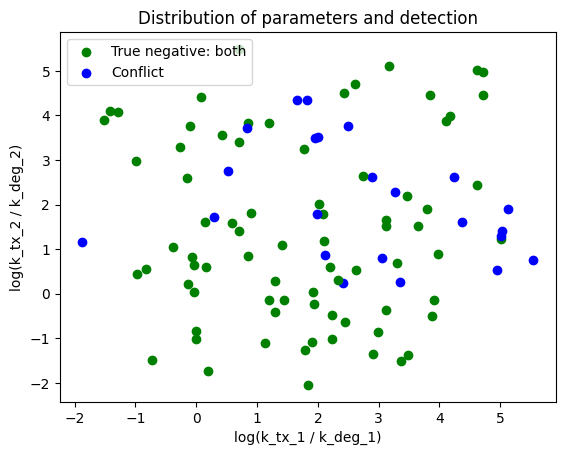

In [406]:
scatter_combined_results(params_high_revised_noInt, solution_dict_high_revised_noInt, solution_dict_high_revised_min_noInt, scale=False, interaction=False)

In [407]:
# high cap eff, combined
result_to_display_combined(
    params_high_revised, solution_dict_high_revised, solution_dict_high_revised_min,
    params_high_revised_noInt, solution_dict_high_revised_noInt, solution_dict_high_revised_min_noInt
)

accuracy = 0.55
precision = 1.0
recall = 0.1
F1 score = 0.18


,Positive,Negative
Predicted Positive,0.05,0.00
Predicted Negative,0.45,0.50


In [408]:
# med cap eff, combined
result_to_display_combined(
    params_med_revised, solution_dict_med_revised, solution_dict_med_revised_min,
    params_med_revised_noInt, solution_dict_med_revised_noInt, solution_dict_med_revised_min_noInt
)

accuracy = 0.6
precision = 0.92
recall = 0.22
F1 score = 0.35


,Positive,Negative
Predicted Positive,0.11,0.01
Predicted Negative,0.39,0.49
